Data after creating features: (50524, 37)
Train/Test sizes: (40419, 37) (10105, 37)

Evaluation metrics on test set:


,MAE,RMSE,MAPE(%)
power,142.8509,245.6893,3.023570e+08
wind_speed,0.5636,0.7856,1.453672e+05
theoretical,173.4251,291.1633,2.309923e+08
wind_dir,11.3148,34.9463,1.073217e+07


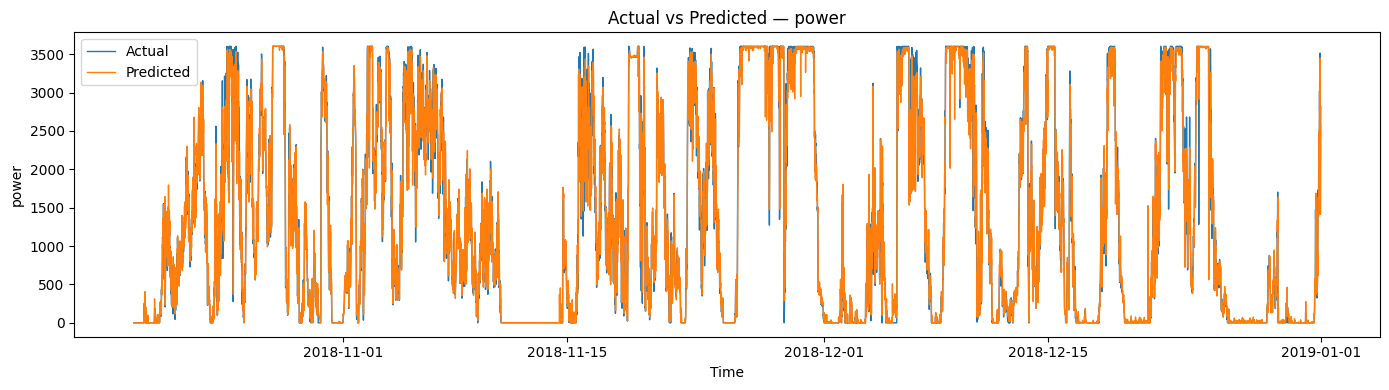

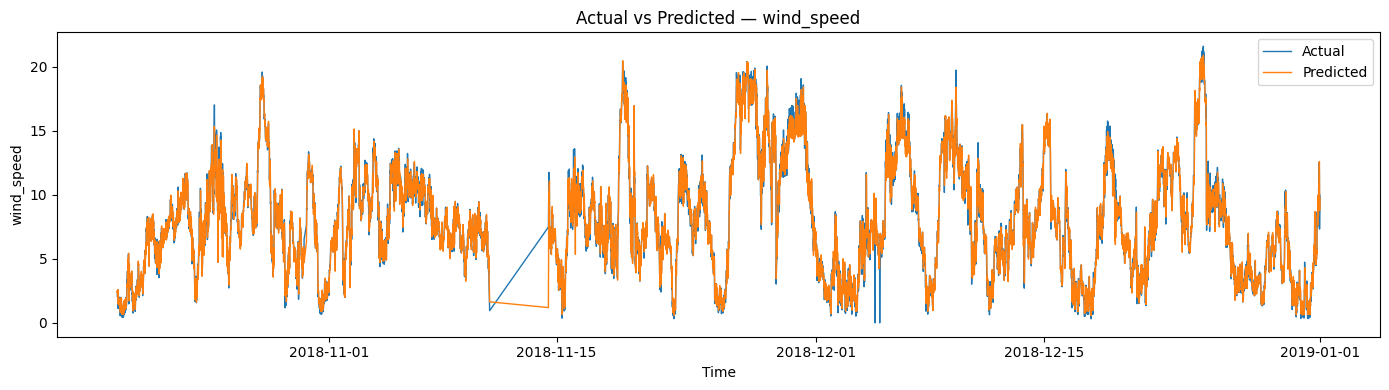

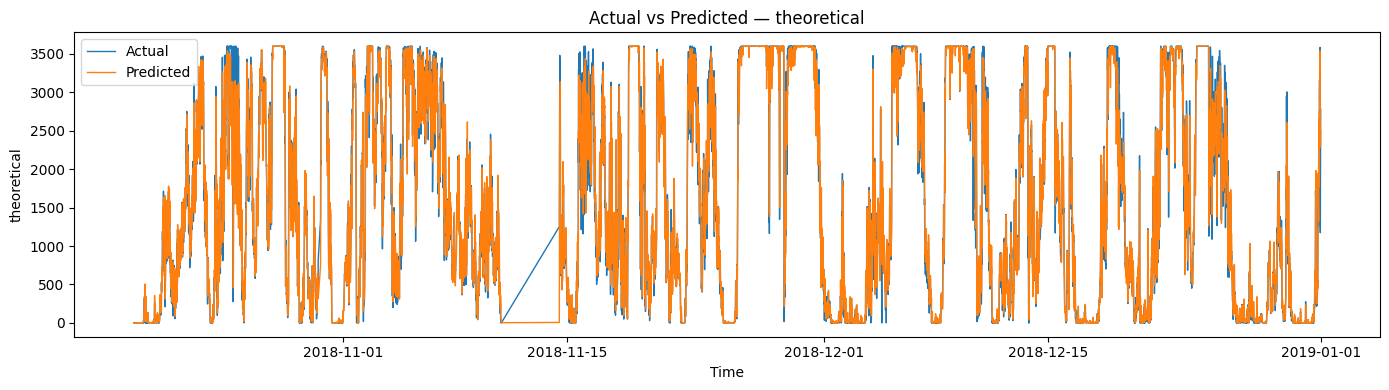

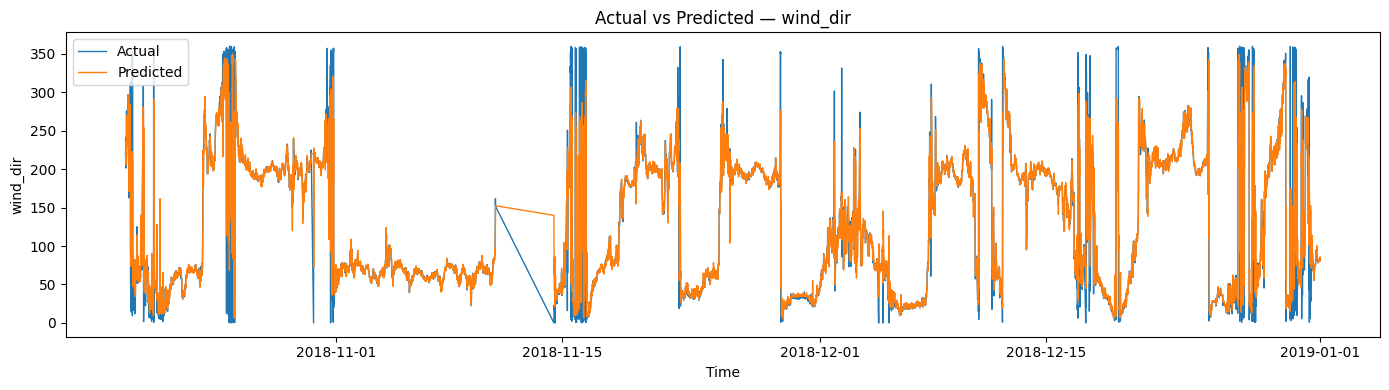

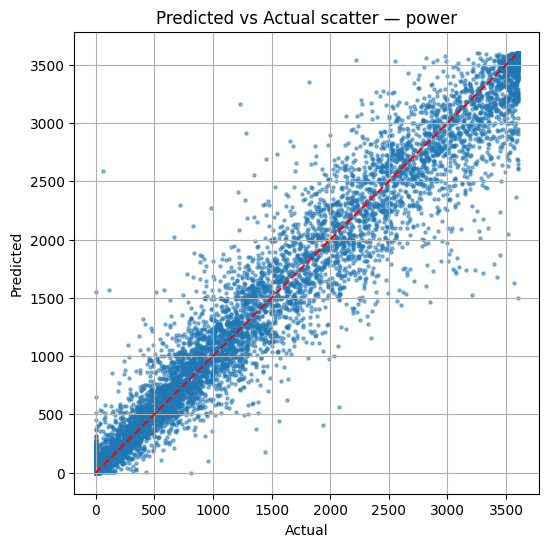

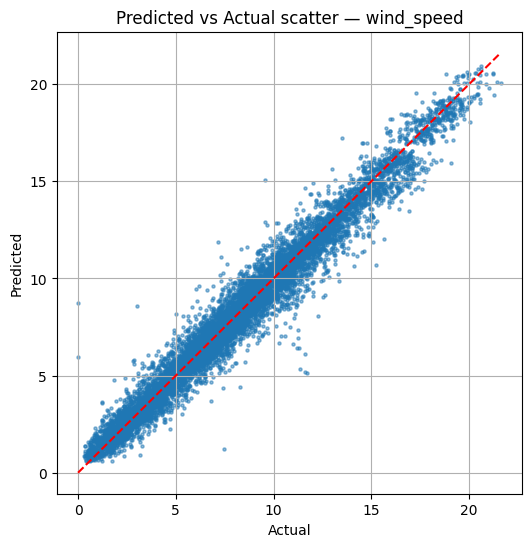

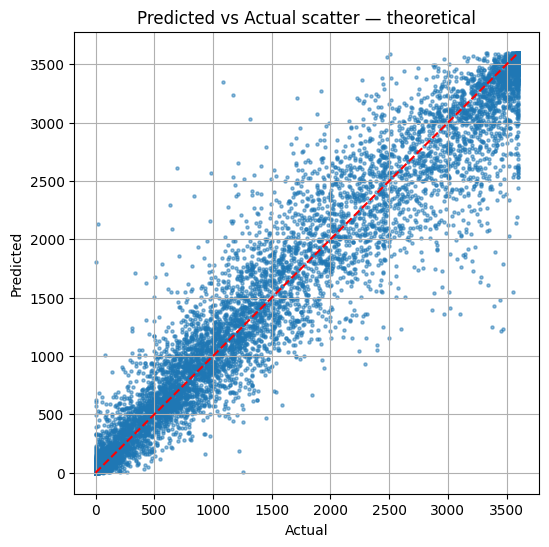

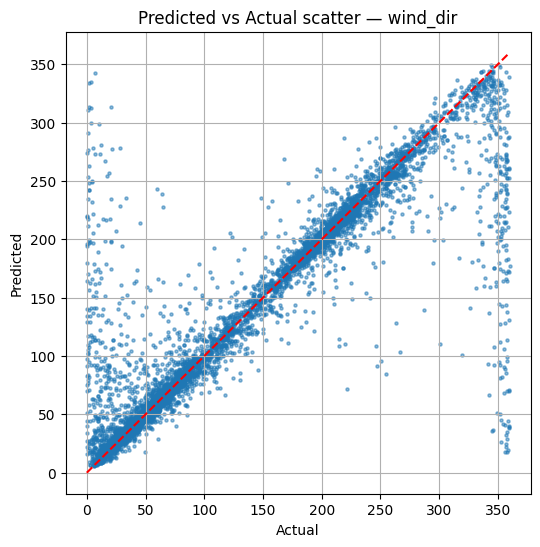

forecast_metrics.csv


In [2]:
# Time-series forecasting for all 4 variables using windowed features and RandomForest models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Load and preprocess
df = pd.read_csv('T1.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
df = df.set_index('Date/Time').sort_index()

# Rename cols for easier use
df = df.rename(columns={
    'LV ActivePower (kW)': 'power',
    'Wind Speed (m/s)': 'wind_speed',
    'Theoretical_Power_Curve (KWh)': 'theoretical',
    'Wind Direction (°)': 'wind_dir'
})

# Keep only needed columns (ensure numeric)
df = df[['power','wind_speed','theoretical','wind_dir']].apply(pd.to_numeric, errors='coerce')

# Create lag features (1 to 6 lags)
n_lags = 6
for col in df.columns:
    for lag in range(1, n_lags+1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Add rolling mean features
for col in ['power','wind_speed','theoretical']:
    df[f'{col}_roll3'] = df[col].rolling(window=3, min_periods=1).mean().shift(1)
    df[f'{col}_roll6'] = df[col].rolling(window=6, min_periods=1).mean().shift(1)

# Add time features (hour of day, minute, dayofweek)
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['dayofweek'] = df.index.dayofweek

# Drop rows with NaNs due to lagging
df_model = df.dropna().copy()
print("Data after creating features:", df_model.shape)

# Train-test split (chronological)
train_frac = 0.8
train_n = int(len(df_model) * train_frac)
train = df_model.iloc[:train_n]
test = df_model.iloc[train_n:]

print("Train/Test sizes:", train.shape, test.shape)

# Features and targets
feature_cols = [c for c in df_model.columns if c not in ['power','wind_speed','theoretical','wind_dir']]
targets = ['power','wind_speed','theoretical','wind_dir']

# Train a RandomForest for each target (one-step ahead)
models = {}
preds = {}
metrics = {}

for target in targets:
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(train[feature_cols], train[target])
    y_pred = rf.predict(test[feature_cols])
    preds[target] = y_pred
    models[target] = rf
    
    # Metrics
    y_true = test[target].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    # MAPE (avoid divide by zero)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(np.abs(y_true) < 1e-6, 1e-6, y_true))) * 100
    metrics[target] = {'MAE': mae, 'RMSE': rmse, 'MAPE(%)': mape}

# Display metrics
metrics_df = pd.DataFrame(metrics).T
print("\nEvaluation metrics on test set:")
display(metrics_df.round(4))

# Plot predicted vs actual for all four variables (use the test index)
plt.rcParams.update({'figure.max_open_warning': 0})
for target in targets:
    plt.figure(figsize=(14,4))
    plt.plot(test.index, test[target], label='Actual', linewidth=1)
    plt.plot(test.index, preds[target], label='Predicted', linewidth=1)
    plt.title(f'Actual vs Predicted — {target}')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

# Also show scatter (pred vs actual) for quick visual
for target in targets:
    plt.figure(figsize=(6,6))
    plt.scatter(test[target], preds[target], s=5, alpha=0.5)
    plt.plot([test[target].min(), test[target].max()], [test[target].min(), test[target].max()], 'r--')
    plt.title(f'Predicted vs Actual scatter — {target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

# Save models to disk (optional) - commented out
# import joblib
# for target,m in models.items():
#     joblib.dump(m, f'model_{target}.joblib')

# Return metrics dataframe for user
metrics_df_round = metrics_df.round(4)
metrics_df_round.to_csv('forecast_metrics.csv')
print("forecast_metrics.csv")
